In [50]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib
#Importing Important libraries
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options

In [3]:
import os
# We initialise the function to read data as required.
# If we pass train.csv in dataSet, we get the training data and if we pass train.csv in dataSet, we get the testing data.
def loadData(dataSet):
    dataPath = os.path.join("data", "")
    csvPath = os.path.join(dataPath, dataSet)
    return pd.read_csv(csvPath)

In [4]:
trainingData = loadData("train.csv")
trainingData.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Mean trip duration is: 6.4645211752676754


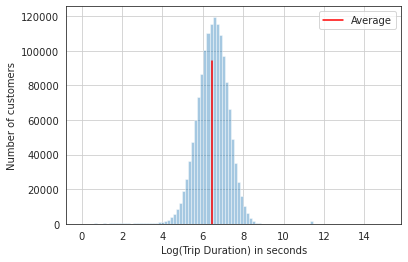

In [5]:
# Here we add a new column named log_trip_duration which is simply the log of trip duration in base 10.
# The plot below shows the log_trip_duration plotted against the number of customers
# As you can clearly see by the red line, the meanTrip duration (in log) is 6.46.
trainingData['log_trip_duration'] = np.log(trainingData['trip_duration'].values)
meanTripDuration = trainingData.log_trip_duration.mean()
print("Mean trip duration is: " + str(meanTripDuration))
with sns.axes_style("white"): 
    trainingData.log_trip_duration.hist(bins=100, alpha=0.4)
    plt.axvline(meanTripDuration, 0, 0.75, color="red", label="Average")
    plt.xlabel("Log(Trip Duration) in seconds")
    plt.ylabel("Number of customers")
    plt.legend()

In [6]:
# Lets check for null values in our data. If the data contains any null values, then while training these might cause error.
# Luckily, our data has no entries which are null and hence we don't need to clean it up.
trainingData.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
log_trip_duration     0
dtype: int64

In [7]:
# This is our training label column. Since we are using supervised learning for this assignment,
# the label will be what we will predict in our testing data.
# trainingLabel = trainingData.pop('trip_duration')

In [8]:
# We change the date time and drop time features in our data to type datetime to make it easier for us to manipulate it.
trainingData["pickup_datetime"] = pd.to_datetime(trainingData["pickup_datetime"])
trainingData["dropoff_datetime"] = pd.to_datetime(trainingData["dropoff_datetime"])

In [9]:
trainingData["weekday"] = trainingData.pickup_datetime.dt.day_name()
trainingData["weekdayNum"] = trainingData.pickup_datetime.dt.weekday
trainingData["month"] = trainingData.pickup_datetime.dt.month
trainingData["pickupHour"] = trainingData.pickup_datetime.dt.hour

In [10]:
trainingData.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,Monday,0,3,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,Sunday,6,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,Tuesday,1,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,Wednesday,2,4,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,Saturday,5,3,13


In [83]:
# Haversine formula to calculate the distance between two pair of given locations consisting of longitudes and latitudes.
# This is difference from the standard distane as this is measured taking in consideration the curvature of earth
# Reference for this formula was taken from:
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
from math import radians, cos, sin, asin, sqrt
def haversine(location1, location2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat1 = location1[0]
    lon1 = location1[1]
    lat2 = location2[0]
    lon2 = location2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [52]:
# Distance function to get the distance between two places.
def distance(dataSet):
    pickuploc = (dataSet["pickup_latitude"], dataSet["pickup_longitude"])
    dropoffloc = (dataSet["dropoff_latitude"], dataSet["dropoff_longitude"])
    return haversine(pickuploc, dropoffloc)

In [53]:
# We add this distance to the training data as a new coloumn for every ride. 
# this will help up to make better predictions using more features
trainingData["distance"] = trainingData.apply(lambda x: distance(x) , axis = 1)

In [54]:
trainingData.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,Monday,0,3,17,1.498521,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,Sunday,6,6,0,1.805507,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,Tuesday,1,1,11,6.385098,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,Wednesday,2,4,19,1.485498,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,Saturday,5,3,13,1.188588,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [55]:
trainingData.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
...,...,...
57,weekdayNum_2,uint8
58,weekdayNum_3,uint8
59,weekdayNum_4,uint8
60,weekdayNum_5,uint8


In [56]:
dummyValue = pd.get_dummies(trainingData.store_and_fwd_flag, prefix="flag")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.vendor_id, prefix="vendor_id")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.passenger_count, prefix="passenger_count")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.pickupHour, prefix="pickupHour")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.month, prefix="month")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

dummyValue = pd.get_dummies(trainingData.weekdayNum, prefix="weekdayNum")
dummyValue.drop(dummyValue.columns[0], axis=1, inplace=True)
trainingData = pd.concat([trainingData, dummyValue], axis = 1)

In [57]:
trainingData.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,...,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6,flag_Y,vendor_id_2,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,Monday,0,3,17,1.498521,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,Sunday,6,6,0,1.805507,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,Tuesday,1,1,11,6.385098,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,Wednesday,2,4,19,1.485498,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,Saturday,5,3,13,1.188588,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [58]:
trainingData.passenger_count.value_counts()

1    1033597
2     210315
5      78088
3      59896
6      48333
4      28404
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [59]:
trainingData.passenger_count.describe()

count    1.458638e+06
mean     1.664571e+00
std      1.314208e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [60]:
# Since the average value of passenger is equal to 1 then lets change the values which are zero to 1 since having 0 
# 0 passenger in a taxi and doing a trip is physically impossible. Further more there are only 60 0 values
# in a data set of 1.4 million values so changing them won't have much effect.
trainingData["passenger_count"] = trainingData.passenger_count.map(lambda x: 1 if x == 0 else x)

In [61]:
trainingData.passenger_count.value_counts()

1    1033597
2     210315
5      78088
3      59896
6      48333
4      28404
7          3
9          1
8          1
Name: passenger_count, dtype: int64

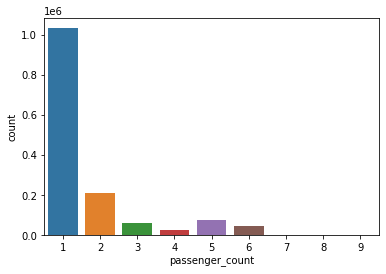

In [62]:
sns.countplot(trainingData.passenger_count)

In [63]:
# Lets see the trips which have more than 24 hrs of travelling time. Since there will be very few,
# it will be safe to remove them from the data as they are outliers and it won't be helpful to take
# them into consideration.
trainingData[trainingData.trip_duration >= 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,...,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6,flag_Y,vendor_id_2,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6


In [64]:
trainingData = trainingData[trainingData.trip_duration <= 86400]

Text(0, 0.5, 'Trip Count')

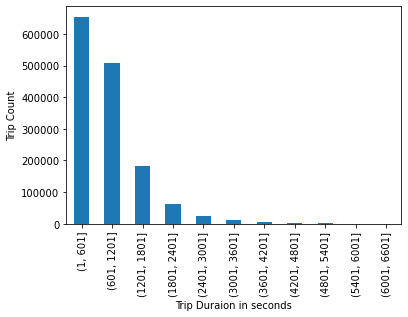

In [65]:
trainingData.trip_duration.groupby(pd.cut(trainingData.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel("Trip Duraion in seconds")
plt.ylabel("Trip Count")

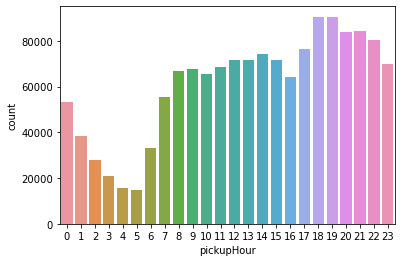

In [66]:
sns.countplot(trainingData.pickupHour)
# This a comlpletely natural plot. The number of pick ups per hour start to increase from 6 am
# as people start to head off to work. It is highest during eveing as people return, or go out for leisure.

In [67]:
trainingData[trainingData.pickup_longitude == trainingData.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,...,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6,flag_Y,vendor_id_2,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
1359910,id3628988,1,2016-05-05 18:21:37,2016-05-05 18:30:45,1,-79.569733,41.586273,-80.355431,42.090183,N,548,6.306275,Thursday,3,5,18,85.884876,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [68]:
# as you see this location is clearly not i new york, but it is somewhere on the west coast. 
# This is an outlier which will cause inconsistency to our model and hence has to be removed
trainingData = trainingData[trainingData.pickup_longitude != trainingData.pickup_longitude.min()]

In [69]:
trainingData[trainingData.pickup_longitude == trainingData.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,...,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6,flag_Y,vendor_id_2,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
1430363,id3073838,1,2016-03-13 05:10:05,2016-03-13 05:17:30,2,-79.4879,40.739159,-79.4879,40.739159,N,445,6.098074,Sunday,6,3,5,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [70]:
# Agin this data is not from new york and has to be removed
trainingData = trainingData[trainingData.pickup_longitude != trainingData.pickup_longitude.min()]

In [71]:
trainingData[trainingData.pickup_longitude == trainingData.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,weekday,weekdayNum,month,pickupHour,distance,flag_Y,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,...,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6,flag_Y,vendor_id_2,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,pickupHour_1,pickupHour_2,pickupHour_3,pickupHour_4,pickupHour_5,pickupHour_6,pickupHour_7,pickupHour_8,pickupHour_9,pickupHour_10,pickupHour_11,pickupHour_12,pickupHour_13,pickupHour_14,pickupHour_15,pickupHour_16,pickupHour_17,pickupHour_18,pickupHour_19,pickupHour_20,pickupHour_21,pickupHour_22,pickupHour_23,month_2,month_3,month_4,month_5,month_6,weekdayNum_1,weekdayNum_2,weekdayNum_3,weekdayNum_4,weekdayNum_5,weekdayNum_6
595540,id1723416,1,2016-03-20 21:07:56,2016-03-20 21:12:35,1,-78.547401,40.817131,-79.786133,40.917637,N,279,5.631212,Sunday,6,3,21,104.759971,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [72]:
list(zip(range(0, len(trainingData.columns)), trainingData.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'log_trip_duration'),
 (12, 'weekday'),
 (13, 'weekdayNum'),
 (14, 'month'),
 (15, 'pickupHour'),
 (16, 'distance'),
 (17, 'flag_Y'),
 (18, 'vendor_id_2'),
 (19, 'passenger_count_1'),
 (20, 'passenger_count_2'),
 (21, 'passenger_count_3'),
 (22, 'passenger_count_4'),
 (23, 'passenger_count_5'),
 (24, 'passenger_count_6'),
 (25, 'passenger_count_7'),
 (26, 'passenger_count_8'),
 (27, 'passenger_count_9'),
 (28, 'pickupHour_1'),
 (29, 'pickupHour_2'),
 (30, 'pickupHour_3'),
 (31, 'pickupHour_4'),
 (32, 'pickupHour_5'),
 (33, 'pickupHour_6'),
 (34, 'pickupHour_7'),
 (35, 'pickupHour_8'),
 (36, 'pickupHour_9'),
 (37, 'pickupHour_10'),
 (38, 'pickupHour_11'),
 (39, 'pickupHour_12'),
 (40, 'pickupHour_13'),
 (41, 'pickupHour_14

In [73]:
Y = trainingData.iloc[:,10].values
X = trainingData.iloc[:,range(16,61)].values
# We did the above to split the data into two np.ndarrray. Y contains the original data columns and
# X conatins the ones we made to help our model.

In [74]:
from sklearn.model_selection import train_test_split
# Lets split the training testing data. 20% data will  for testing and rest for training.
testSplit = 0.2
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, random_state=4, test_size=testSplit)
# Here Xtrain is our training data with Ytrain being the training labels.
# Xtest is testing data with Ytest being the testing predictions.

In [75]:
from sklearn.linear_model import LinearRegression
modelLinearRegression = LinearRegression()
modelLinearRegression.fit(Xtrain, Ytrain)

LinearRegression()

In [76]:
Ypred = modelLinearRegression.predict(Xtest)

In [77]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Ytest, Ypred))

3220.330541467469

In [78]:
import math
for i in range(0, len(Ypred)):
    Ypred[i] = abs(Ypred[i])

In [79]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(Ytest, Ypred)

0.4483938572927785

In [80]:
from sklearn.ensemble import RandomForestRegressor
modelRandomForestRegressor = RandomForestRegressor(n_jobs=-1, verbose=3)
modelRandomForestRegressor.fit(Xtrain, Ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100building tree 6 of 100building tree 7 of 100


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.9min finished


RandomForestRegressor(n_jobs=-1, verbose=3)

In [81]:
YpredRFR = modelRandomForestRegressor.predict(Xtest)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.2s finished


In [82]:
mean_squared_log_error(Ytest, YpredRFR)

0.35882586816264284

In [91]:
from sklearn.linear_model import SGDRegressor
modelSGD = SGDRegressor(loss='epsilon_insensitive', verbose=3)
modelSGD.fit(Xtrain, Ytrain)

-- Epoch 1
Norm: 188.67, NNZs: 45, Bias: 113.563918, T: 1166908, Avg. loss: 410.287849
Total training time: 0.63 seconds.
-- Epoch 2
Norm: 191.45, NNZs: 45, Bias: 132.187027, T: 2333816, Avg. loss: 392.406229
Total training time: 1.14 seconds.
-- Epoch 3
Norm: 194.70, NNZs: 45, Bias: 142.155976, T: 3500724, Avg. loss: 390.658943
Total training time: 1.62 seconds.
-- Epoch 4
Norm: 197.31, NNZs: 45, Bias: 148.625878, T: 4667632, Avg. loss: 389.656084
Total training time: 2.08 seconds.
-- Epoch 5
Norm: 199.67, NNZs: 45, Bias: 153.437792, T: 5834540, Avg. loss: 388.915434
Total training time: 2.53 seconds.
-- Epoch 6
Norm: 202.45, NNZs: 45, Bias: 157.418015, T: 7001448, Avg. loss: 388.321480
Total training time: 3.01 seconds.
-- Epoch 7
Norm: 205.71, NNZs: 45, Bias: 160.885659, T: 8168356, Avg. loss: 387.825655
Total training time: 3.47 seconds.
-- Epoch 8
Norm: 208.33, NNZs: 45, Bias: 163.753912, T: 9335264, Avg. loss: 387.400707
Total training time: 3.95 seconds.
-- Epoch 9
Norm: 211.09,

SGDRegressor(loss='epsilon_insensitive', verbose=3)

In [92]:
YpredSGD = modelSGD.predict(Xtest)

In [95]:
# import math
# for i in range(0, len(YpredSGD)):
#     YpredSGD[i] = abs(YpredSGD[i])
mean_squared_log_error(Ytest, YpredSGD)

0.28255966087037243